In [187]:
from itertools import combinations,combinations_with_replacement
import networkx as nx
import matplotlib.pyplot as plt
import subprocess
from xml.etree import cElementTree as ET
import sys
import numpy as np

color_map = {0:'r', 1:'b', 2:'g', 3:'black', 4:'orangered', 5:'m', 6:'y'}

def poly_value(coef_vec,x):
    value = 0
    reverse_vec = coef_vec
    reverse_vec.reverse()
    for coef in reverse_vec:
        value = coef + value*x
    return value

class Pos:
    
    def __init__(self,i = 0,j = 0):
        self.i = i
        self.j = j
        
    def __str__(self):
        return f'({self.i},{self.j})'
    
    def __add__(self, other):
        #радиус-вектор
        return Pos(self.i+other.i,self.j+other.j)
    
    def __sub__(self, other):
        return Pos(self.i-other.i,self.j-other.j)
    
    def __mul__(self, other):
        try:
            return Pos(self.i*other,self.j*other) 
        except:
            print(f'{type(self)} and {type(other)} are not multiply')
            
    def __rmul__(self, other):
        try:
                return Pos(self.i*other,self.j*other) 
        except:
            print(f'{type(self)} and {type(other)} are not multiply')
    
    def __truediv__(self, other):
        try:
            return Pos(self.i/other,self.j/other)
        except:
            print(f'{type(self)} and {type(other)} are not divisible')
    
    def __abs__(self):
        return (self.i**2 + self.j**2)**0.5
    
    
    def __eq__(self, other):
        if type(self) == Pos and type(other) == Pos:
            return (self.i == other.i) and (self.j == other.j)   
        
        return False
    
    
    def __hash__(self):
        return hash((self.i,self.j))
    
    
    def around(self,dist=1,grid_size=1):
        
        neighbors = [self]
        if dist >= grid_size:
            for x in np.arange(grid_size,dist,grid_size):
                neighbors += [Pos(self.i-x,self.j),Pos(self.i+x,self.j),
                              Pos(self.i,self.j-x),Pos(self.i,self.j+x)]
            if (dist-1) % grid_size == 0:
                neighbors += [Pos(self.i-dist,self.j),Pos(self.i+dist,self.j),
                              Pos(self.i,self.j-dist),Pos(self.i,self.j+dist)]
            for x in np.arange(grid_size,dist+(1e-1),grid_size):
                for y in np.arange(grid_size,(dist**2 - x**2)**0.5+(1e-1),grid_size):
                    if x**2 + y**2 <= dist**2:
                        neighbors += [Pos(self.i-x,self.j-y),Pos(self.i-x,self.j+y),
                                      Pos(self.i+x,self.j-y),Pos(self.i+x,self.j+y),
                                      Pos(self.i-y,self.j-x),Pos(self.i-y,self.j+x),
                                      Pos(self.i+y,self.j-x),Pos(self.i+y,self.j+x),]

        return neighbors

    
    def get_distance(self,other,mode=0):
        if mode:
            return abs(self.i - other.i) + abs(self.j - other.j)
        
        return ((self.i - other.i)**2 + (self.j - other.j)**2)**0.5
    
    
    
class Agent:
        
    def __init__(self,player_id = None,pos = None):
        self.player_id = player_id
        self.pos = pos
        
    def __str__(self):
        return f'<player_id = {self.player_id}, pos = {self.pos}>'
    
    def is_neighbour(self,other,dist):
        return self.pos.get_distance(other.pos) <= dist
    
    def neighbors_pos(self,dist=1,grid_size=1):
        return self.pos.around(dist,grid_size)
    

    
class Network:
    
    def __init__(self):
        self.agents = []
        self.drons = []
        self.graph = nx.Graph()
        self.players_id = []
        self.r = 1 #радиус 
        self.grid_size = 1
        
    def __str__(self):
        return f'<agents = {list(map(str,self.agents))}>'
        
    def add_agent(self, new_agent):
        neighbours = []
        for obj in (self.agents):
            if obj.player_id == new_agent.player_id :
                if obj.pos.get_distance(new_agent.pos) <= self.r:
                    neighbours.append(obj)
                    
        for obj in (self.drons):
            if obj.pos.get_distance(new_agent.pos) <= self.r:
                neighbours.append(obj)            
        
        self.graph.add_node(new_agent)  
        
        if new_agent.player_id not in self.players_id:
            self.players_id.append(new_agent.player_id)
        self.graph.add_node(new_agent)
            
        for neighbour in neighbours:
            if new_agent.player_id == neighbour.player_id:
                self.graph.add_edge(new_agent,neighbour)
            
        self.agents.append(new_agent)

        
    def add_agents(self, new_agent_list):
        for new_agent in new_agent_list:
            self.add_agent(new_agent)
            
    def add_dron(self, new_dron):            
        neighbours = []
        for obj in (self.drons+self.agents):
            if obj.pos.get_distance(new_dron.pos) <= self.r:
                neighbours.append(obj)
        self.graph.add_node(new_dron)  
        
        if len(neighbours) > 0:
            for neighbour in neighbours:
                self.graph.add_edge(new_dron,neighbour)

                    
        self.drons.append(new_dron)
        
    def add_drons(self, new_dron_list):
        for new_dron in new_dron_list:
            self.add_dron(new_dron)
            
    def del_dron(self, dron):
        if self.drons.count(dron) != 0:
            self.drons.remove(dron)
            self.graph.remove_node(dron)
                
    def del_drons(self, drons_list):
        for dron in drons_list:
            self.del_dron(dron)
        
    def create_graph(self):
        self.graph = nx.Graph()
        for agent in self.agents:
            self.graph.add_node(agent)
        for agent in self.agents:
            for other_agent in self.agents:
                if agent.is_neighbour(other_agent) and agent.player_id == other_agent.player_id:
                    self.graph.add_edge(agent,other_agent) 
                    
        for dron in self.drons:
            self.graph.add_node(dron)
        for dron in self.drons:
            for other in (self.drons+self.agents):
                if dron.is_neighbour(other):
                    self.graph.add_edge(dron,other)        
        return self.graph
            
    def draw_graph(self, visible_players_list = None,possible_positions = None,pngname=None):   
        G = self.graph.copy()
        G.remove_nodes_from(self.drons)
        subgraphs = [G.subgraph(c) for c in nx.connected_components(G)]
#         Упорядочим подграфы по номерам игроков
        subgraphs = {list(subgraph)[0].player_id: subgraph for subgraph in subgraphs}
        if visible_players_list == None:
            visible_players_list = list(subgraphs.keys())
        pos = {agent: (agent.pos.i+agent.player_id*0.1,agent.pos.j-agent.player_id*0.1) for agent in self.agents}
        pos.update({dron: (dron.pos.i,dron.pos.j) for dron in self.drons})     
        for i in visible_players_list:   
            nx.draw_networkx_nodes(self.graph, pos, node_size=150, nodelist=subgraphs[i], node_color=color_map[i-1])
        nx.draw_networkx_nodes(self.graph, pos, node_size=150, nodelist=self.drons, node_color="gold") 
        nx.draw_networkx_edges(self.graph, pos, edgelist = self.graph.edges, alpha=0.5, width=1)
        
        if possible_positions != None:
            possible_drons = [Agent(pos=possible_position) for possible_position in possible_positions]  
            self.graph.add_nodes_from(possible_drons)
            pos = {possible_dron: (possible_dron.pos.i,possible_dron.pos.j) for possible_dron in possible_drons}
            nx.draw_networkx_nodes(self.graph, pos, node_size=140, nodelist=possible_drons, node_color="black", node_shape = "8")    
            nx.draw_networkx_nodes(self.graph, pos, node_size=110, nodelist=possible_drons, node_color="w", node_shape = "8")
            self.graph.remove_nodes_from(possible_drons)
        plt.axis("on")
        if pngname != None:
            plt.savefig(pngname)
        plt.show()
    
    def get_player_subnet(self, p_id, with_drons=False):
        subgraph = self.graph.copy()
        remove_list = []
        for node in subgraph.nodes:
            if node.player_id != p_id:
                if not with_drons:
                    remove_list.append(node)
                elif node.player_id != 0:
                    remove_list.append(node)
        subgraph.remove_nodes_from(remove_list)
        if with_drons:
            nodes = []
            for node in list(subgraph.nodes):
                if node.player_id != 0:
                    nodes.append(node)
        else:
            nodes = list(subgraph.nodes)
        subnet = Network()
        subnet.add_agents(nodes)
        if with_drons:
            subnet.add_drons(self.drons)
        return subnet
        
    def get_possible_grid_positions(self,grid_size=1):
        positions = set()
        agents_pos = {}
        for agent in network.agents:
            positions.update(agent.neighbors_pos(network.r,network.grid_size))
        
        possible_positions = {}
        for pos in positions:
            player_set = set()
            agents_list = []
            for agent in network.agents:
                if pos.get_distance(agent.pos) <= network.r:
                    player_set.add(agent.player_id)
                    agents_list.append(agent)
            if len(player_set) > 1 and possible_positions.get(tuple(agents_list)) == None:
                possible_positions[tuple(agents_list)] = pos        
        
#         intersection_dict = {}
#         for agent_tuple,point_pos in possible_positions.items():  
#             largest = 1
#             for other_agent_tuple in possible_positions.keys():
#                 if agent_tuple != other_agent_tuple:
#                     if set(agent_tuple).issubset(set(other_agent_tuple)):
#                         largest = 0
#                         break

#             if largest:       
#                 intersection_dict[agent_tuple] = point_pos             
                
        return list(possible_positions.values())
 


    def get_possible_positions(self):
        a = tuple(set(self.agents))
        intersections = [[],[]]
        
        for p1 in range(len(a)):
            for p2 in range(p1+1,len(a)):
                if a[p1].player_id != a[p2].player_id:
                    dist = a[p1].pos.get_distance(a[p2].pos)
                    if dist == 0:
                        intersections[0] += [[]]
                        intersections[1] += [a[p1].pos]
                        
                    elif dist < 2*self.r:
                        h = (self.r**2-(dist/2)**2)**0.5
                        p12 = (a[p2].pos-a[p1].pos)
                        center = a[p1].pos + p12/2
                        pos_a = Pos(center.i+(h/dist)*p12.j,center.j-(h/dist)*p12.i)
                        pos_b = Pos(center.i-(h/dist)*p12.j,center.j+(h/dist)*p12.i)
                        intersections[0] += [[],[]]
                        intersections[1] += [pos_a,pos_b]
                        
                    elif dist == 2*self.r:        
                        intersections[0] += [[]]
                        intersections[1] += [a[p1].pos+(a[p2].pos-a[p1].pos)/2]
                    
        for i in range(len(intersections[1])):
            for agent in a:
                if intersections[1][i].get_distance(agent.pos) <= self.r:
                    intersections[0][i].append(agent)

        intersection_dict = {}
        
        for agent_tuple,point_pos in zip(intersections[0],intersections[1]):  
            agent_tuple = tuple(agent_tuple)
            
            if intersection_dict.get(agent_tuple) == None:                    
                max_len = 0
                for intersection in intersections[0]:
                    if set(agent_tuple).issubset(set(intersection)):
                        if max_len < len(intersection):
                            max_len = len(intersection)

                if len(agent_tuple) == max_len:       
                    if intersection_dict.get(agent_tuple) == None:
                        intersection_dict[agent_tuple] = [point_pos]
                    else:
                        intersection_dict[agent_tuple].append(point_pos)

        values = list(intersection_dict.values())
        return list(map(lambda x: np.mean(np.array(x)),values))



    def get_pos_value(self,alpha,position):
        dron = Agent(pos = position)
        self.add_dron(dron)
        value = self.get_value(alpha)
        self.del_dron(dron)
        return value 
    
    def get_value(self,alpha):
        len_ways_vec = [0 for i in range(len(self.agents)+len(self.drons))] 
        shotest_ways = []
        for s in self.agents:
            for t in self.agents:
                if s.player_id != t.player_id: 
                    if nx.has_path(self.graph, source=s, target=t):
                        for path in list(nx.all_shortest_paths(self.graph, source=s, target=t)):
                            shotest_ways.append(path)
#         Считаем производящую функцию сразу для всех дронов
        for path in shotest_ways:
            for dron in self.drons:
                if dron in list(path):
                    len_ways_vec[len(path)-1] += 1/len(path)
                    break                  
                
        return poly_value(len_ways_vec[1:],alpha)
    
    def get_value_cc(self):
        cc = nx.closeness_centrality(self.graph)
        val = 0
        for dron in self.drons:
            val += cc[dron]   
        return val
    
    def get_value_bc(self):
        bc = nx.betweenness_centrality(self.graph)
        val = 0
        for dron in self.drons:
            val += bc[dron]         
        return val
    
    
    def get_value_dc(self):
        dc = nx.degree_centrality(self.graph)
        val = 0
        for dron in self.drons:
            val += dc[dron]            
        return val

    
    def get_best_positions(self,possible_positions,alpha,drons_count=None,mode=0):
        if drons_count == None:
            drons_count = len(self.players_id)-1
            
        max_val = 0
        best_set = None

        if len(possible_positions) >= drons_count:
            for positions in combinations(possible_positions, drons_count):
                drons = [Agent(pos = position) for position in positions]
                network.add_drons(drons)
                if nx.is_connected(network.graph):
                    if mode == 0:
                        cur_value = network.get_value(alpha)
                    else:
                        cur_value = 1/network.get_value(alpha)
                    if cur_value > max_val:
                        max_val = cur_value
                        best_set = positions
                network.del_drons(drons)

        else:
            for positions in combinations_with_replacement(possible_positions, drons_count):
                drons = [Agent(pos = position) for position in positions]
                network.add_drons(drons)
                if nx.is_connected(network.graph):
                    if mode == 0:
                        cur_value = network.get_value(alpha)
                    else:
                        cur_value = 1/network.get_value(alpha)
                    if cur_value > max_val:
                        max_val = cur_value
                        best_set = positions
                network.del_drons(drons)
        return best_set
    
    

        
    
    def write_info_file(self,drons_pos=None,filename = 'my_network_with_nodes.txt'):
        if type(drons_pos) is list or type(drons_pos) is tuple:
            drons_list = [Agent(pos = dron_pos) for dron_pos in drons_pos]
            self.add_drons(drons_list)
            adj_matrix = nx.to_numpy_matrix(self.graph,dtype ='int')
        elif type(drons_pos) is Pos:   
            dron = Agent(pos = drons_pos)
            self.add_dron(dron)
            adj_matrix = nx.to_numpy_matrix(self.graph,dtype ='int')
        else:
            adj_matrix = nx.to_numpy_matrix(self.graph,dtype ='int')
        with open(filename,'w') as file:
            file.write(str(len(self.agents))+' '+str(len(self.drons))+'\n')
            for agent in self.agents:
                file.write(str(agent.pos.i) + ' ' + str(agent.pos.j) + ' ' + str(agent.player_id) +'\n')
            for dron in self.drons:
                file.write(str(dron.pos.i) + ' ' + str(dron.pos.j) + '\n')
            str_matrix = ''
            for i in range(adj_matrix.shape[0]):     
                for j in range(adj_matrix.shape[1]):
                    str_matrix += (str(adj_matrix[i,j])+' ')
                str_matrix += '\n'
            file.write(str_matrix)
                 
        subnetA = self.get_player_subnet(1,True)
        if type(drons_pos) is list or type(drons_pos) is tuple:
            for dron in drons_list.copy():
                if len(list(subnetA.graph.neighbors(dron))) < 2:
                    subnetA.del_dron(dron)
        elif type(drons_pos) is Pos:
            if len(list(subnetA.graph.neighbors(dron))) < 2:
                subnetA.del_dron(dron)
                
        subnetB = self.get_player_subnet(2,True)  
        if type(drons_pos) is list or type(drons_pos) is tuple:
            for dron in drons_list.copy():
                if len(list(subnetB.graph.neighbors(dron))) < 2:
                    subnetB.del_dron(dron)
        elif type(drons_pos) is Pos:
            if len(list(subnetB.graph.neighbors(dron))) < 2:
                subnetB.del_dron(dron)
        
        if type(drons_pos) is list or type(drons_pos) is tuple:
            self.del_drons(drons_list)
        elif type(drons_pos) is Pos:
            self.del_dron(dron)
            


In [248]:
def parse_flowmon(info_xml = 'p2p_manet.flowmon'):
    et=ET.parse(info_xml)
    txPackets = []
    rxPackets = []
    lostPackets = []
    delays = []

    for flow in et.iterfind('FlowStats/Flow'):
        txPackets.append(int(flow.get('txPackets')))
        rxPackets.append(int(flow.get('rxPackets')))
        lostPackets.append(int(flow.get('lostPackets')))
        delays.append(float(flow.get('delaySum')[:-2]))

    info_list = [txPackets,rxPackets,lostPackets,delays]
    return info_list    

def plot_sum_bar(info_list,title='',xlabel='',ylabel='',legend_labels=['Первый случай','Второй случай','Модуль разности'],multiplier=2,_width=1,pngname=None):
    fig, ax = plt.subplots(figsize=[6.4*multiplier, 4.8*multiplier])
    plt.title(title, fontsize=20)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel(ylabel, fontsize=15)

    if legend_labels != None:
        for i in range(len(info_list)):
            ax.plot(1+i*_width, (info_list[i]), label = legend_labels[i])
        ax.legend(fontsize = 'x-large')
    
    for i in range(len(info_list)):
        ax.bar(1+i*_width,(info_list[i]), width = _width)

    if pngname != None:
        plt.savefig(pngname)
    plt.show()


def plot_sum_bars(info_list,legend_labels=['Случай без дронов','Первый случай','Второй случай']):
    
    changed_info = [[],[],[],[]]
    
    for info in info_list:
        changed_info[0] += [info[3]]
        changed_info[1] += [info[2]]
        changed_info[2] += [info[0]]
        changed_info[3] += [info[1]]
        
    for info in changed_info:
        for i in range(len(info)):
            info[i] = sum(info[i])
    
    pngnames = ['delays_sum.png','lostPackets_sum.png','txPackets_sum.png','rxPackets_sum.png']
    plot_sum_bar(changed_info[0],title='Сравнение задержек в сумме',xlabel='Наборы позиций',
                 ylabel='Задержка, нс',legend_labels=legend_labels,pngname=pngnames[0])
    
    percent_received = []
    for i in range(len(changed_info[0])):
        percent_received.append(100*changed_info[1][i]/changed_info[2][i])
    plot_sum_bar(percent_received,title='Пакетов потеряно в сети',xlabel='Наборы позиций',
                 ylabel='Пакетов потеряно, %',legend_labels=legend_labels,pngname=pngnames[3])
    
    
def plot_bar(list1,list2,title='',xlabel='',ylabel='',legend_labels=['Первый случай','Второй случай'],multiplier=1.5,_width=0.4,pngname=None):
    x1 = [i-_width*0.5 for i in range(len(list1))]
    x2 = [i+_width*0.5 for i in range(len(list2))]
    fig, ax = plt.subplots(figsize=[6.4*multiplier, 4.8*multiplier])
    
    plt.title(title, fontsize=20)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel(ylabel, fontsize=15)
    
    ax.plot(x1, list1, '', label = legend_labels[0])
    ax.plot(x2, list2, '', label = legend_labels[1])

    ax.legend(fontsize = 'x-large')
 
    ax.bar(x1, list1, width = _width)
    ax.bar(x2, list2, width = _width)
    if pngname != None:
        plt.savefig(pngname)
    plt.show()

def plot_bars(info_list,info_list2):
    txPackets,rxPackets,lostPackets,delays = info_list
    txPackets2,rxPackets2,lostPackets2,delays2 = info_list2
    
    pngnames = ['delays.png','lostPackets.png','txPackets.png','rxPackets.png']
    plot_bar(delays,delays2,title='Сравнение задержек',xlabel='Flow id',ylabel='Delays in ns',pngname=pngnames[0])
    plot_bar(lostPackets,lostPackets2,title='Пакетов потеряно',xlabel='Flow id',ylabel='Lost packets',pngname=pngnames[1])
    plot_bar(txPackets,txPackets2,title='Пакетов отправлено',xlabel='Flow id',ylabel='Transmitted packets sum',pngname=pngnames[2])
    plot_bar(rxPackets,rxPackets2,title='Пакетов принято',xlabel='Flow id',ylabel='Received packets sum',pngname=pngnames[3])

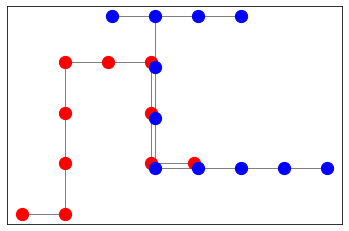

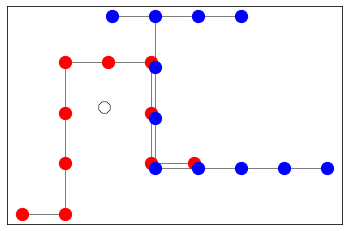

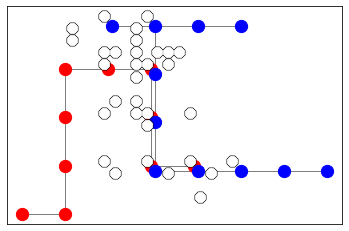

32


In [317]:
# player1Pos = [[1,1],[1,2],[2,2],[2,3],[2,4],[3,3]]

# player2Pos = [[3,1],[4,1],[4,2],[5,2],[5,3]]

# l = 10
    
# player1Pos = [[1,i] for i in range(l)]

# player2Pos = [[3,i] for i in range(l)]

# player1Pos = [[0,0],[1,0],[2,0],[2,1],[2,2],[1,2],[0,2],[0,3]]

# player2Pos = [[4,0],[5,0],[6,0],[6,1],[6,2],[6,3],[5,3],[4,3],[4,2]]




# player1Pos = [[3,3],[4,2],[4,3],[4,4],[4,5],[5,5],[6,5],[7,5],[7,4],[7,3],[7,2],[8,2],[7,1]]

# player2Pos = [[3,5],[4,5],[5,5],[6,5],[4,4],[4,3],[4,2],[5,2],[6,2],[7,2],[8,2]]

player1Pos = [[1,1],[2,1],[2,2],[2,3],[2,4],[3,4],[4,4],[4,3],[4,2],[5,2]]

player2Pos = [[3,5],[4,5],[5,5],[6,5],[4,4],[4,3],[4,2],[5,2],[6,2],[7,2],[8,2]]

# player1Pos = [[-3,-2],[-2,-2],[-1,-2],[0,-2],[-2,0],[-3,-1],[-3,0],[-3,1],[-1,0],[0,-1],[1,-1],[2,-1],[0,0],[0,1],[1,1],[1,2],[2,1],[2,2],[2,3],[2,4],[3,3],[4,3],[4,4],[4,5],[3,5],[2,5],[4,6],[2,0]]

# player2Pos = [[3,-3],[3,-2],[4,-2],[3,1],[4,1],[4,2],[5,2],[5,3],[5,4],[5,5],[3,0],[3,-1],[4,-1],[5,-1],[5,0],[5,1]]




# player1Pos = [[2,1],[2,2],[2,3],[1,3],[1,2],[1,4],[1,5],[2,5],[3,5]]

# player2Pos = [[4,3],[5,3],[5,2],[6,2],[7,2],[7,3],[7,4],[7,5],[6,5],[5,5]]

# player1Pos = [[0,0],[1,0],[2,0],[0,1],[1,1],[2,1],[0,2],[1,2],[2,2],[1.5,0.5],[0.5,0.5],[0.5,-0.5],[-0.5,-0.5],[0,-1]]

# player2Pos = [[4,0],[5,0],[6,0],[4,1],[5,1],[6,1],[4,2],[5,2],[6,2]]



player1AgentsNumber = len(player1Pos)
player2AgentsNumber = len(player2Pos)

player1Agents = [Agent(1,Pos(i,j)) for (i,j) in player1Pos]
player2Agents = [Agent(2,Pos(i,j)) for (i,j) in player2Pos]


network = Network()
network.r = 1
network.grid_size = 0.25
alpha = 3
network.add_agents(player1Agents)
network.add_agents(player2Agents)
network.draw_graph(pngname='orig_graph')



# network.add_dron(Agent(pos = best_positions[0]))

# network.grid_size = 0.5

# possible_positions = network.get_possible_grid_positions()
# network.draw_graph(possible_positions = possible_positions,pngname='example1_grid')
# best_positions = network.get_best_positions(possible_positions,2.,1)
# network.draw_graph(possible_positions = best_positions,pngname='example1_result')


possible_positions = network.get_possible_positions()
best_positions = network.get_best_positions(possible_positions,alpha,1,mode=1)
# network.draw_graph(possible_positions = possible_positions,pngname='possible_positions')
network.draw_graph(possible_positions = best_positions)

possible_positions = network.get_possible_grid_positions()
network.draw_graph(possible_positions = possible_positions,pngname='possible_positions')
print(len(possible_positions))

# drons = [Agent(pos=pos) for pos in best_positions]
# network.add_drons(drons)
# network.draw_graph()
# network.del_drons(drons)


network.write_info_file(best_positions,'my_network_with_nodes.txt')
i = 1
for positions in combinations(possible_positions, 1):
    if positions != best_positions:
        i += 1
        network.write_info_file(positions,'my_network_with_nodes'+str(i)+'.txt')  
        


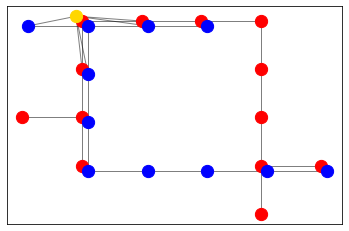

1


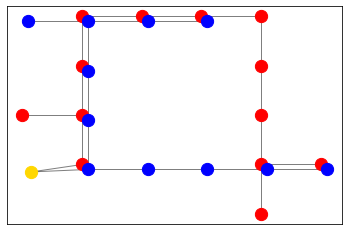

2


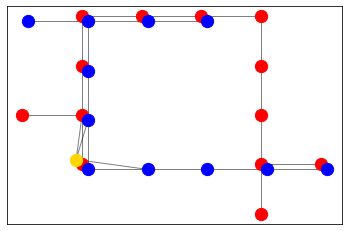

3


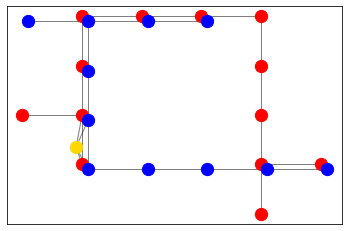

4


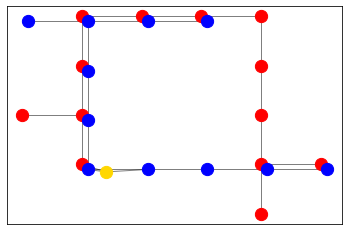

5


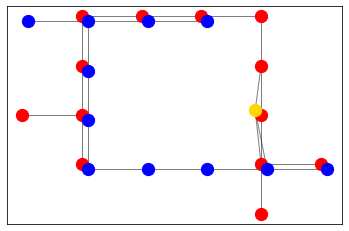

6


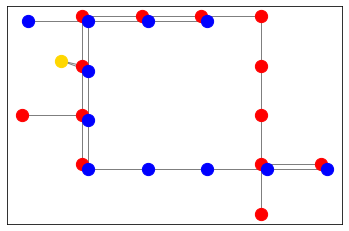

7


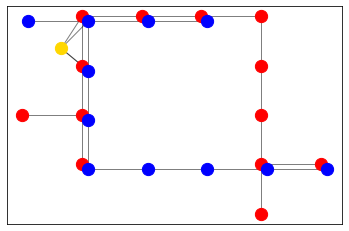

8


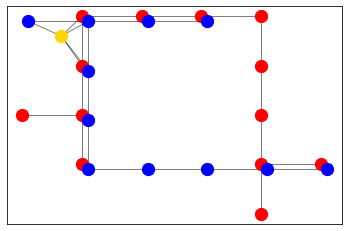

9


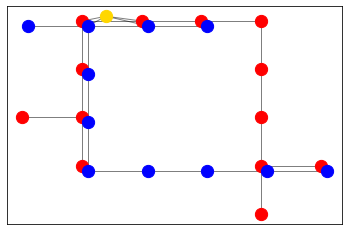

10


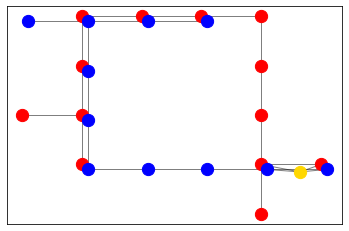

11


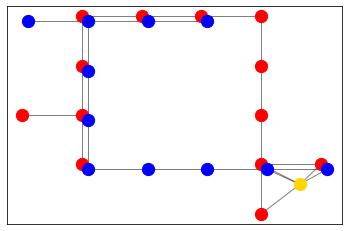

12


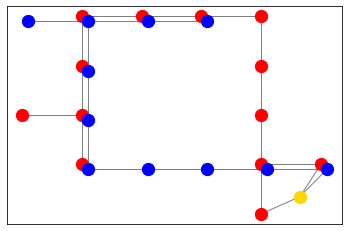

13


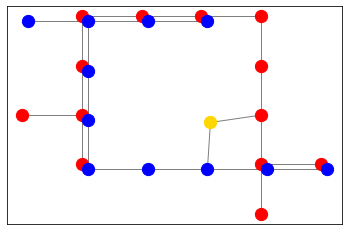

14


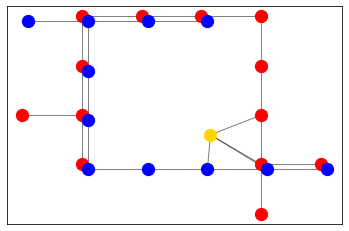

15


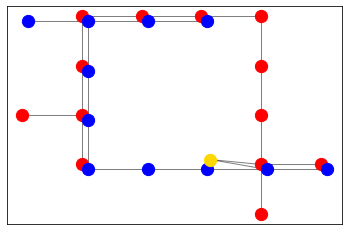

16


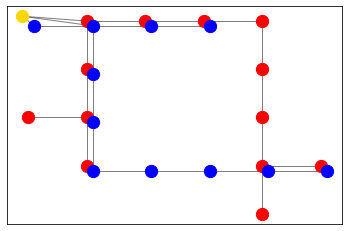

17


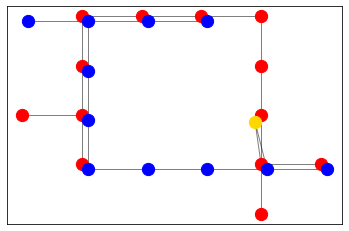

18


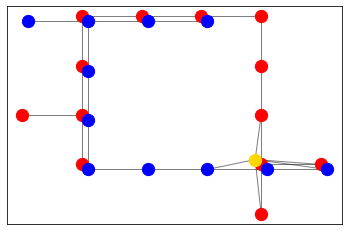

19


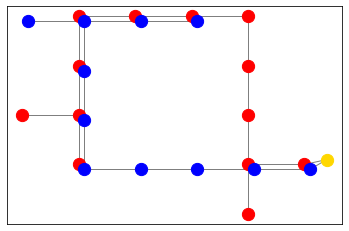

20


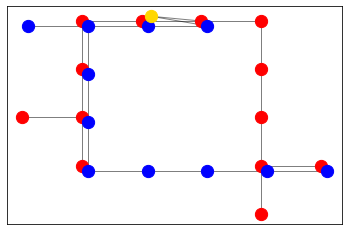

21


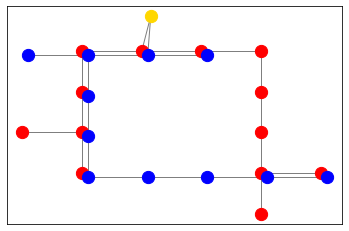

22


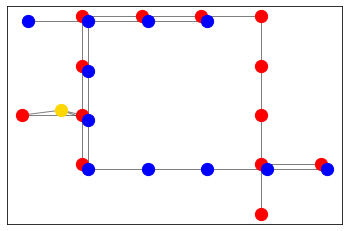

23


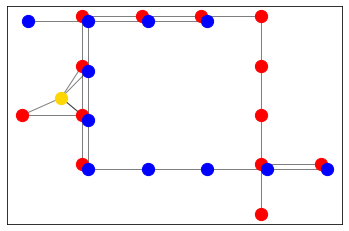

24


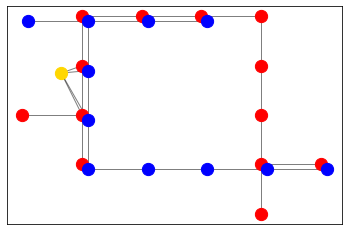

25


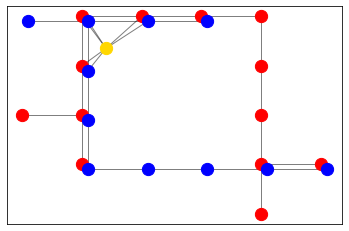

26


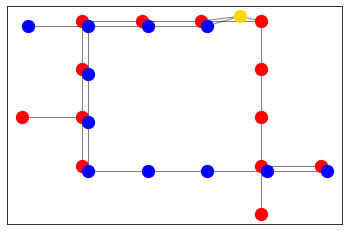

27


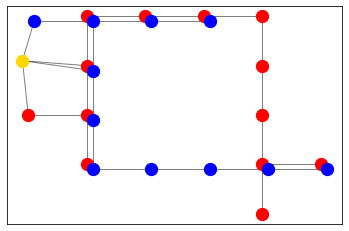

28


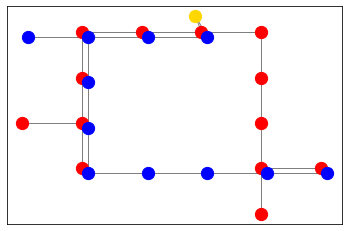

29


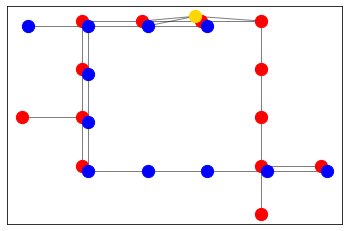

30


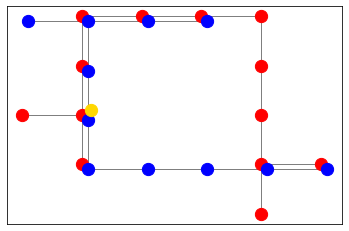

31


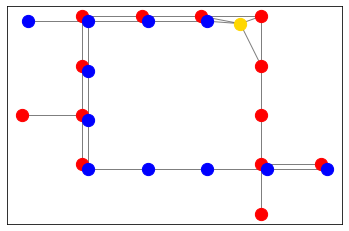

32


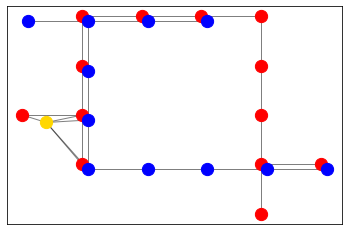

33


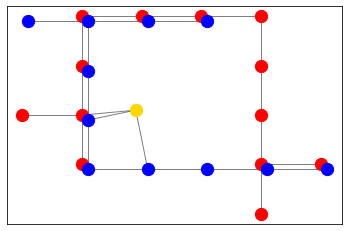

34


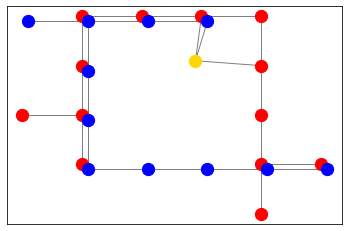

35


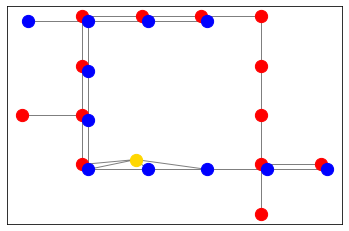

36


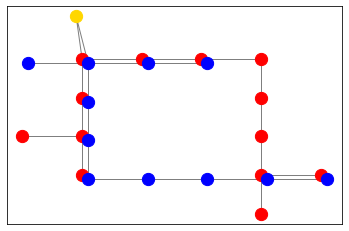

37


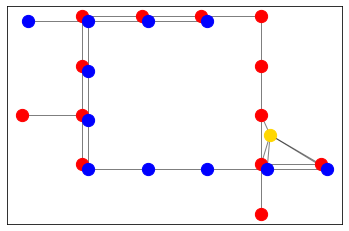

38


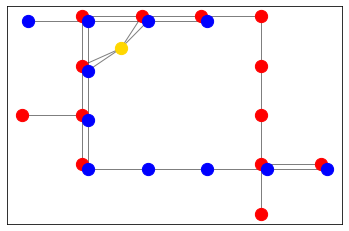

39


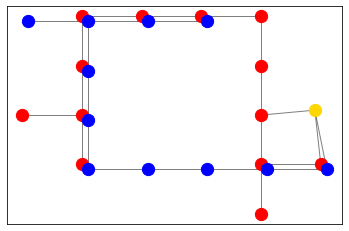

40


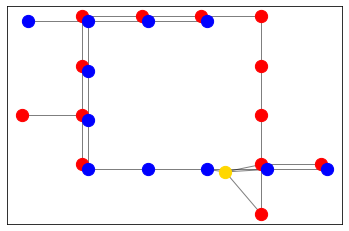

41


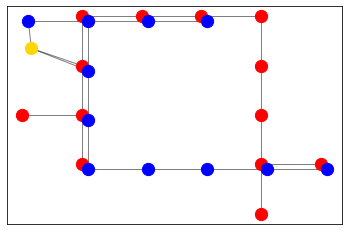

42


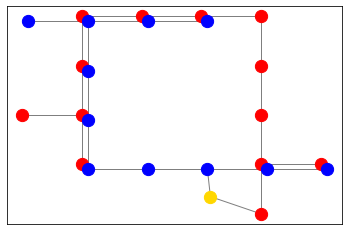

43


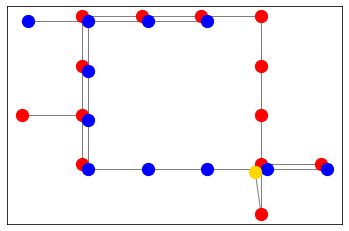

44


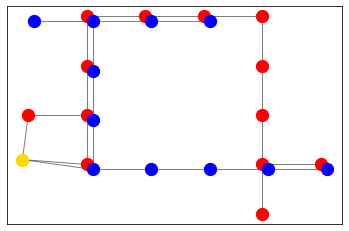

45


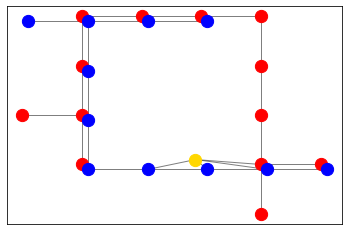

46


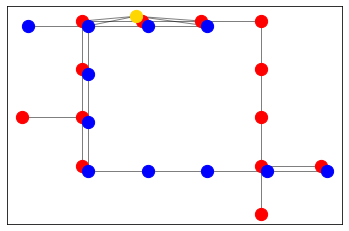

47


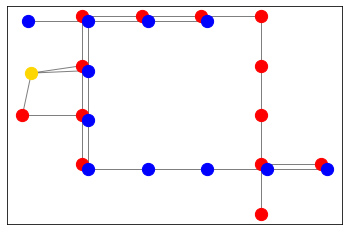

48


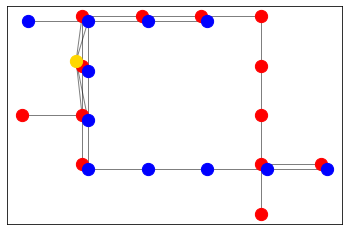

49


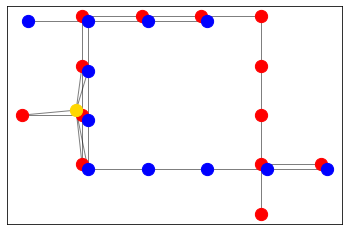

In [277]:
mean_len_list = []
measure_list = []
cc_list,bc_list,dc_list = [],[],[]

drons = [Agent(pos=pos) for pos in best_positions]
network.add_drons(drons)
mean_len_list.append(nx.average_shortest_path_length(network.graph))
measure_list.append(1/network.get_value(alpha))
cc_list.append(network.get_value_cc())
bc_list.append(network.get_value_bc())
dc_list.append(network.get_value_dc())

network.draw_graph(pngname='graph.png')
network.del_drons(drons)

i = 1
for positions in combinations(possible_positions, 1):
    if positions != best_positions:
        drons = [Agent(pos=position) for position in positions]
        network.add_drons(drons)
        print(i)
        i += 1    
        mean_len_list.append(nx.average_shortest_path_length(network.graph))
        measure_list.append(1/network.get_value(alpha))
        cc_list.append(network.get_value_cc())
        bc_list.append(network.get_value_bc())
        dc_list.append(network.get_value_dc())
        network.draw_graph(pngname='graph'+str(i)+'.png')
        network.del_drons(drons)


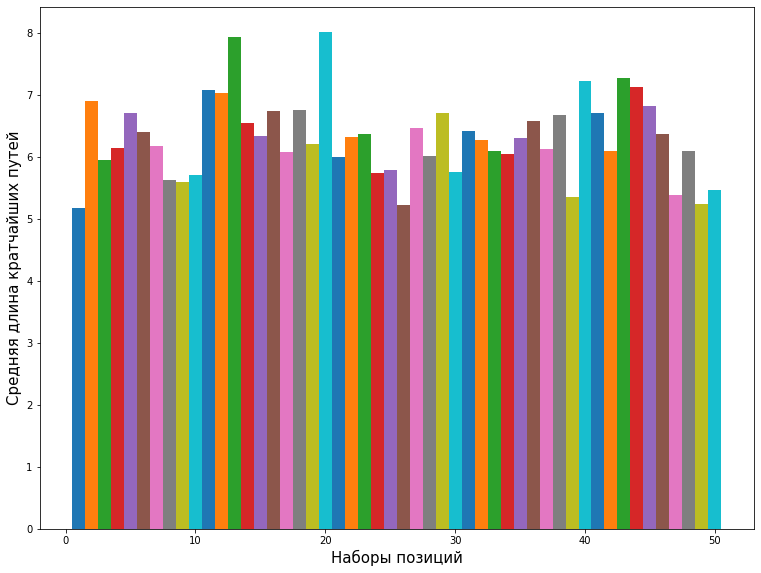

In [278]:
plot_sum_bar(mean_len_list,title='',xlabel='Наборы позиций',
                 ylabel='Средняя длина кратчайших путей',legend_labels=None,pngname='mean_len_bars.png')

In [279]:
index = 0
min = mean_len_list[index]
for i in range(len(mean_len_list)):
    if mean_len_list[i] < min:
        index = i
print(index,mean_len_list[index])
print(0,mean_len_list[0])

0 5.173333333333333
0 5.173333333333333


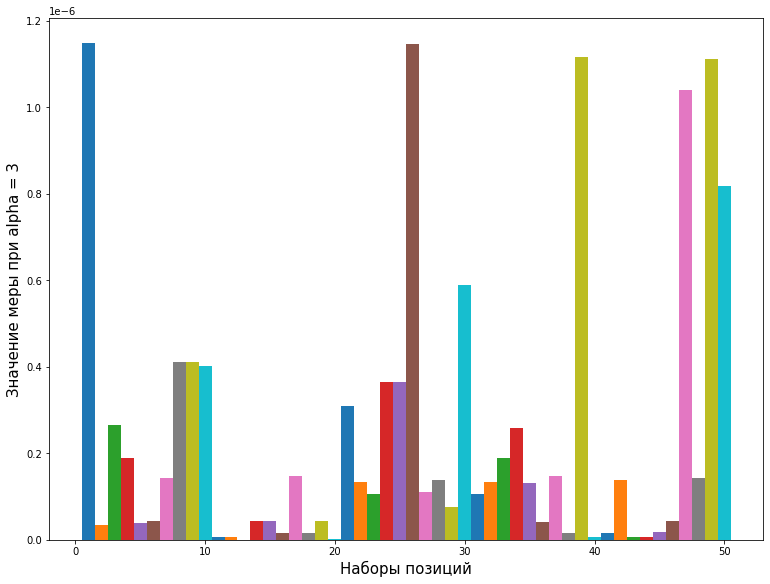

In [280]:
plot_sum_bar(measure_list,title='',xlabel='Наборы позиций',
                 ylabel='Значение меры при alpha = '+str(alpha),legend_labels=None,pngname='mc_value_bars.png')

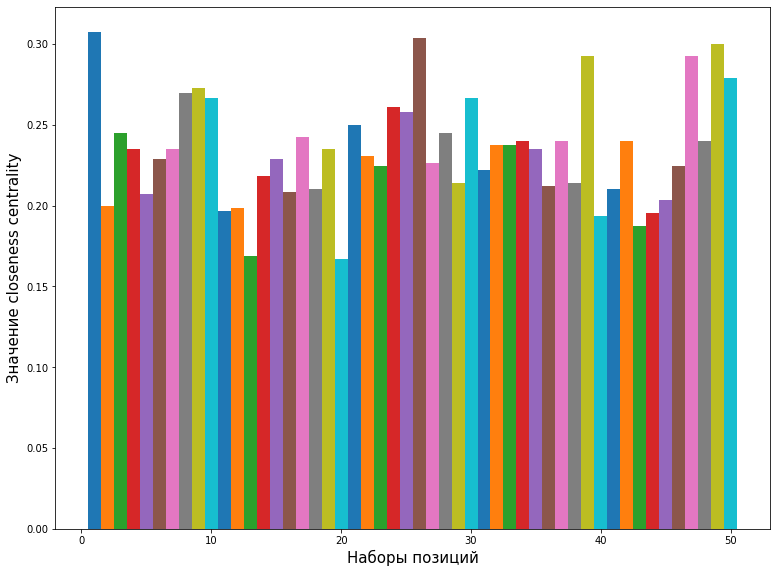

In [281]:
plot_sum_bar(cc_list,title='',xlabel='Наборы позиций',
                 ylabel='Значение сloseness centrality',legend_labels=None,pngname='cc_value_bars.png')

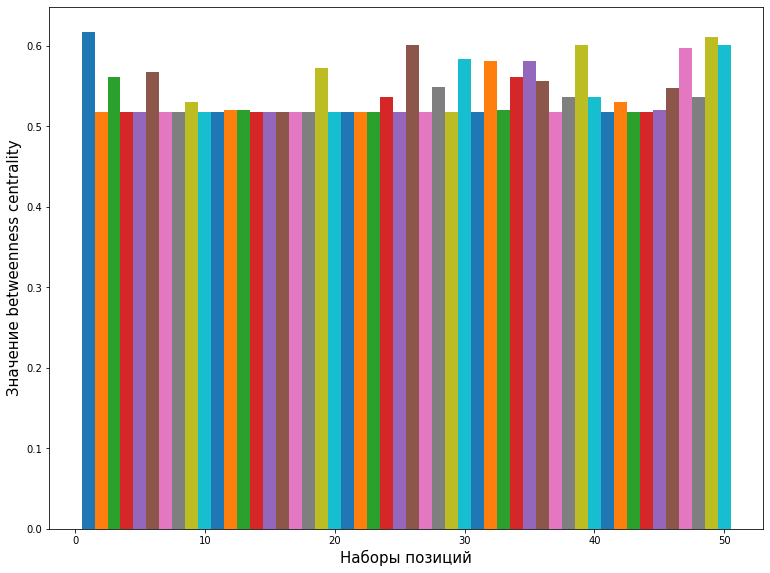

In [282]:
plot_sum_bar(bc_list,title='',xlabel='Наборы позиций',
                 ylabel='Значение betweenness centrality',legend_labels=None,pngname='bc_value_bars.png')

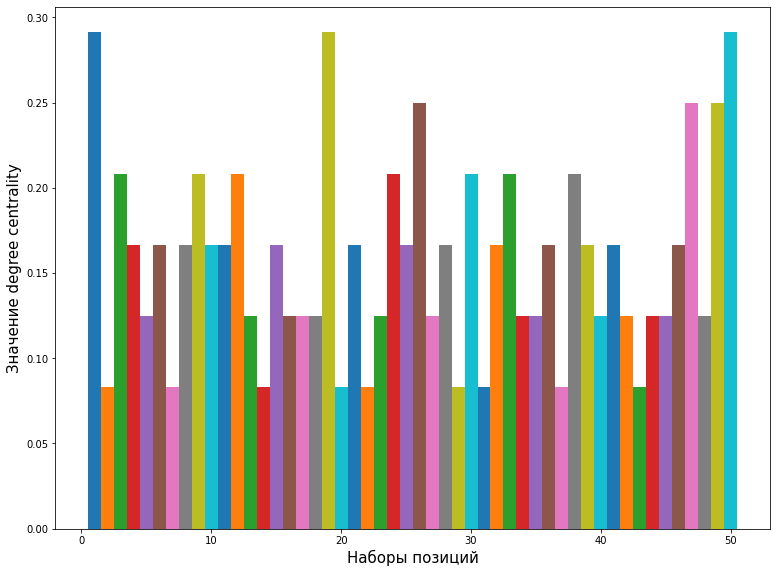

In [283]:
plot_sum_bar(dc_list,title='',xlabel='Наборы позиций',
                 ylabel='Значение degree centrality',legend_labels=None,pngname='dc_value_bars.png')

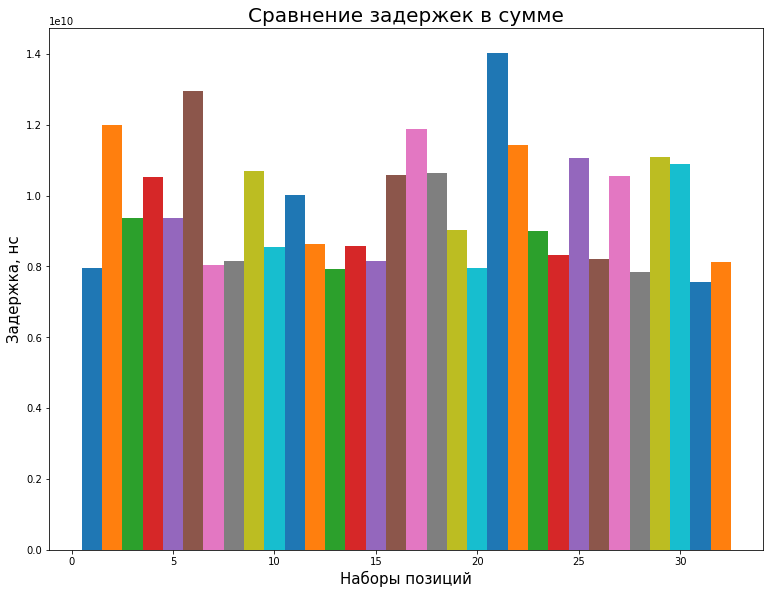

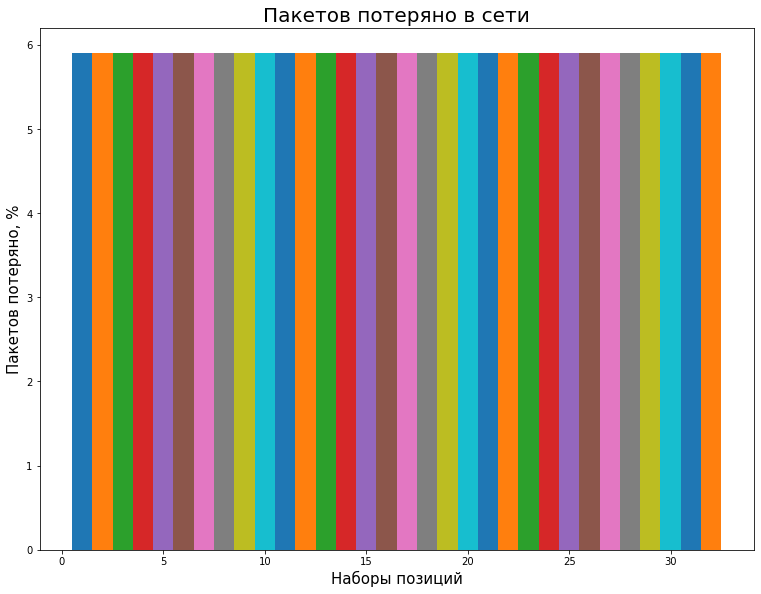

In [324]:
info_list = [parse_flowmon('p2p_manet.flowmon')]

for i in range(2,len(possible_positions)+1):
# for i in range(2,16+1):   
    info_list.append(parse_flowmon('p2p_manet'+str(i)+'.flowmon'))
    
    
plot_sum_bars(info_list,legend_labels=None)